<a href="https://colab.research.google.com/github/subhamchatterjee21/NETFLIX-clone/blob/main/Audio_similarity_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


MessageError: Error: credential propagation was unsuccessful

In [3]:
from os.path import join
import librosa
from IPython.display import Audio

In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 36.6 MB/s eta 0:00:00


In [ ]:
!pip install openl3


  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.4/323.4 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for openl3: filename=openl3-0.4.2-py2.py3-none-any.whl size=249327028 sha256=d7e5bfef346f7b3d07a1a2fba1a72fefdae3c1de9d01b64849b96e633d7e2632
  Stored in directory: /root/.cache/pip/wheels/d0/4d/0a/e57b1dc8ead91b3c5709d9de4f02d1cdd3a91f609a8f1c1062
  Created wheel for kapre: filename=kapre-0.3.7-py3-none-any.whl size=29603 sha256=8d053d79e4aa435994e8c324793919b3f1c67221aa6e623e7678cd521022f12f
  Stored in directory: /root/.cache/pip/wheels/3e/54/f9/37e9f36590a5431dc207f7dc0eb2e607ff8958d5728e45ef58
  Created wheel for resampy: filename=resampy-0.2.2-py3-none-any.whl size=320705 sha256=2a52aaf3125fe56e6720eb65f76a5976671b5dfc1caecba7df0caff31463298f
  Stored in directory: /root

In [ ]:
import librosa
import openl3
import faiss
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Load the audio file
file_path_bn= "/content/drive/MyDrive/bn/cv-corpus-17.0-delta-2024-03-15/bn/clips/common_voice_bn_39620358.mp3"
audio, sr = librosa.core.load(file_path_bn, sr=44100, mono=True)

file_path_as= "/content/drive/MyDrive/Ass/cv-corpus-16.1-2023-12-06/as/clips/common_voice_as_20870771.mp3"
audio_as, sr = librosa.core.load(file_path_as, sr=44100, mono=True)



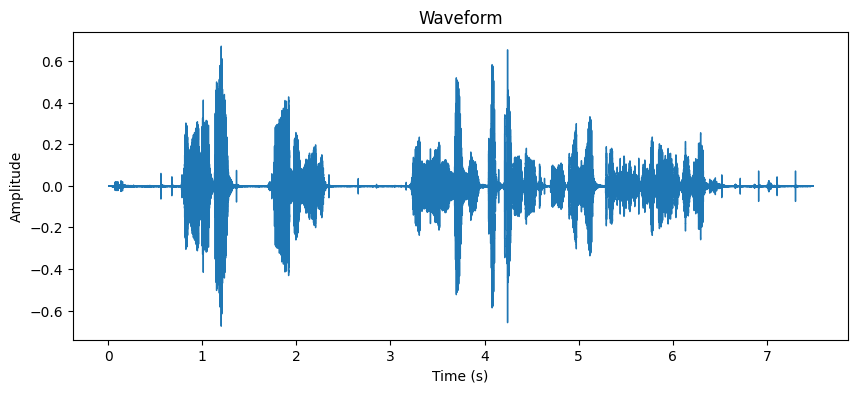

In [ ]:
# Bengali
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()
print("")
display(Audio(audio, rate=3000))

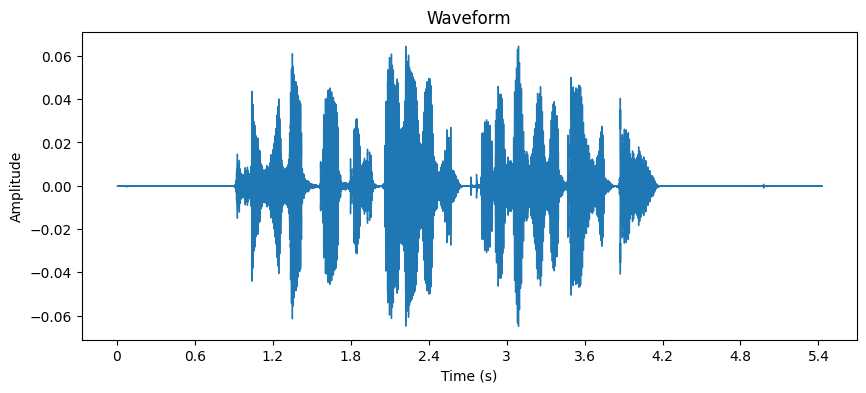

In [ ]:

# Assamese
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio_as, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()
print("")
display(Audio(audio_as, rate=sr))

In [ ]:
open_emb_bn, ts_bn = openl3.get_audio_embedding(audio, sr, input_repr="mel128", frontend='librosa')
open_emb_as, ts_as = openl3.get_audio_embedding(audio_as, sr, input_repr="mel128", frontend='librosa')

3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 9s/step


In [ ]:
open_emb_bn.shape, open_emb_bn.mean(axis=0).shape, open_emb_bn.mean(axis=0)[:20]

((71, 6144),
 (6144,),
 array([ 1.4450815 , -0.15435283,  0.9156204 ,  2.5596013 ,  1.3798891 ,
         0.9531595 ,  0.08747082,  0.50656825,  2.9590423 ,  1.4529153 ,
         1.4980214 ,  2.6363606 ,  1.8598173 ,  0.2746963 ,  1.7768384 ,
         2.5856378 ,  1.2708335 ,  1.2436343 ,  1.7852309 ,  0.75940555],
       dtype=float32))

In [ ]:
open_emb_as.shape, open_emb_as.mean(axis=0).shape, open_emb_as.mean(axis=0)[:20]

((51, 6144),
 (6144,),
 array([ 1.295338  , -0.11444752,  1.1039095 ,  3.0095882 ,  1.2152923 ,
         0.9320353 ,  0.26731744,  0.3695488 ,  3.2742994 ,  1.6183394 ,
         1.842118  ,  2.6830413 ,  1.7645392 ,  0.34795734,  1.6474932 ,
         2.7751257 ,  1.5123336 ,  1.3065507 ,  2.0026073 ,  1.2016735 ],
       dtype=float32))

In [ ]:
# Normalize embeddings
open_emb_bn /= np.linalg.norm(open_emb_bn, axis=1, keepdims=True)
open_emb_as /= np.linalg.norm(open_emb_as, axis=1, keepdims=True)


In [ ]:
# Build FAISS index for Assamese embeddings
index_as = faiss.IndexFlatIP(open_emb_as.shape[1])
index_as.add(open_emb_as)

In [ ]:
# Define Bengali embeddings as query
query_embedding_bn = open_emb_bn.mean(axis=0)  # Using mean embedding of Bengali audio as query
query_embedding_bn /= np.linalg.norm(query_embedding_bn)  # Normalize query embedding

In [ ]:
# Perform search using Bengali query on Assamese embeddings index
k = 2  # Number of nearest neighbors to retrieve
distances, indices = index_as.search(np.expand_dims(query_embedding_bn, axis=0), k)

In [ ]:
from IPython.display import Audio

# Print results
print("Top {} most similar Assamese embeddings to Bengali query:".format(k))
for i, (distance, index) in enumerate(zip(distances[0], indices[0])):
    print("Rank {}: Distance = {:.4f}, Index = {}".format(i+1, distance, index))
    # Load and play similar Assamese audio corresponding to the top-ranked embeddings
    similar_audio_as, _ = librosa.core.load(file_path_as, sr=sr, mono=True)
    print("Playing similar Assamese audio for rank {}...".format(i+1))
    display(Audio(similar_audio_as, rate=sr))

Top 2 most similar Assamese embeddings to Bengali query:
Rank 1: Distance = 0.9538, Index = 14
Playing similar Assamese audio for rank 1...


Rank 2: Distance = 0.9536, Index = 18
Playing similar Assamese audio for rank 2...
